# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import os

# Load datasets
Load both the 30s and 3s features.

In [ ]:
# Load datasets
print("Loading datasets...")
file_path_30sec = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv"
file_path_3sec = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv"

df_30sec = pd.read_csv(file_path_30sec)
print(f"30-sec dataset loaded with shape: {df_30sec.shape}")

# Try loading the 3-sec dataset if it exists
try:
    df_3sec = pd.read_csv(file_path_3sec)
    print(f"3-sec dataset loaded with shape: {df_3sec.shape}")
    use_combined = True
except:
    print("3-sec dataset not found or couldn't be loaded. Using only 30-sec dataset.")
    use_combined = False


Loading datasets...
30-sec dataset loaded with shape: (1000, 60)
3-sec dataset loaded with shape: (9990, 60)


# Preprocessing
Includes merging the 30s and 3s features into a single dataset. To implement this, we used a **label encoder** and scaled the data appropiately to avoid large differences between the 30s features and the 3s features.

In [3]:
# Data preparation function
def prepare_data(df):
    # Drop filename column if it exists
    if 'filename' in df.columns:
        df = df.drop(columns=['filename'])
    
    # Separate features and labels
    X = df.drop(columns=['label']).values
    y = df['label'].values
    
    return X, y

In [4]:
# Prepare datasets
print("Preparing 30-sec dataset...")
X_30sec, y_30sec = prepare_data(df_30sec)
print(f"30-sec data: X shape: {X_30sec.shape}, y shape: {y_30sec.shape}")

# Encode labels consistently (fit on 30sec labels first to ensure consistency)
print("Encoding labels...")
label_encoder = LabelEncoder()
y_30sec_encoded = label_encoder.fit_transform(y_30sec)
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Initialize scalers
scaler_30sec = StandardScaler()

# Scale features
print("Standardizing 30-sec features...")
X_30sec_scaled = scaler_30sec.fit_transform(X_30sec)

if use_combined:
    print("Preparing 3-sec dataset...")
    X_3sec, y_3sec = prepare_data(df_3sec)
    print(f"3-sec data: X shape: {X_3sec.shape}, y shape: {y_3sec.shape}")
    
    # Use the same encoder for 3-sec labels
    y_3sec_encoded = label_encoder.transform(y_3sec)
    
    # Check if feature dimensions match
    if X_3sec.shape[1] != X_30sec.shape[1]:
        print(f"Warning: Feature dimensions don't match! 30-sec: {X_30sec.shape[1]}, 3-sec: {X_3sec.shape[1]}")
        print("Using only 30-sec dataset")
        use_combined = False
    else:
        # Scale 3-sec features using 30-sec scaler
        print("Standardizing 3-sec features...")
        X_3sec_scaled = scaler_30sec.transform(X_3sec)
        
        # Combine datasets
        print("Combining datasets...")
        X_combined = np.vstack([X_30sec_scaled, X_3sec_scaled])
        y_combined_encoded = np.concatenate([y_30sec_encoded, y_3sec_encoded])
        print(f"Combined dataset: {X_combined.shape} features, {len(y_combined_encoded)} labels")

# Set input dimension and data to use
input_dim = X_30sec_scaled.shape[1]
if use_combined:
    X_data = X_combined
    y_data = y_combined_encoded
    print("Using combined dataset for training")
else:
    X_data = X_30sec_scaled
    y_data = y_30sec_encoded
    print("Using only 30-sec dataset for training")

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Convert to categorical for loss function compatibility
print("Converting labels to categorical...")
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
print("Conversion complete")


Preparing 30-sec dataset...
30-sec data: X shape: (1000, 58), y shape: (1000,)
Encoding labels...
Number of classes: 10
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Standardizing 30-sec features...
Preparing 3-sec dataset...
3-sec data: X shape: (9990, 58), y shape: (9990,)
Standardizing 3-sec features...
Combining datasets...
Combined dataset: (10990, 58) features, 10990 labels
Using combined dataset for training
Splitting data...
Train set: (8792, 58), Test set: (2198, 58)
Converting labels to categorical...
Conversion complete


# Model Architecture
Includes a function to define model with self-attention and residual connections

In [5]:
optimizers = {
    "Adam": keras.optimizers.Adam(learning_rate=0.001),
    "SGD": keras.optimizers.SGD(learning_rate=0.004, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001)
}

models = {}

def build_advanced_model(input_dim, num_classes, optimizer):
    # Input layer
    inputs = keras.Input(shape=(input_dim,))
    
    # Self-attention mechanism
    # Reshape for attention
    attention_input = keras.layers.Reshape((input_dim, 1))(inputs)
    
    # Multi-head attention layer
    attention = keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=4
    )(attention_input, attention_input)
    
    # Reshape back to original dimensions
    attention = keras.layers.Reshape((input_dim,))(attention[:, :, 0])
    
    # Combine original input with attention features
    x = keras.layers.Concatenate()([inputs, attention])
    
    # First dense block
    x = keras.layers.Dense(512, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # First residual block
    residual = x
    x = keras.layers.Dense(512, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(512, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.add([x, residual])  # Skip connection
    
    # Second dense block
    x = keras.layers.Dense(256, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # Second residual block
    residual = x
    x = keras.layers.Dense(256, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(256, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.add([x, residual])  # Skip connection
    
    # Third dense block
    x = keras.layers.Dense(128, activation='selu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output layer
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

for name, optimizer in optimizers.items():
    models[name] = build_advanced_model(input_dim, num_classes, optimizer)
    models[name].summary()
    



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 58)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 58, 1)          │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 58, 1)          │            113 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 58)             │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 58)             │              0 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 116)            │              0 │ input_layer[0][0],     │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │         59,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        262,656 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512)            │              0 │ batch_normalization_2… │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 892,155 (3.40 MB)

 Trainable params: 887,291 (3.38 MB)

 Non-trainable params: 4,864 (19.00 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 58)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 58, 1)          │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 58, 1)          │            113 │ reshape_2[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 58)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 58)             │              0 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 116)            │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │         59,904 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 512)            │          2,048 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 512)            │        262,656 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 512)            │          2,048 │ dense_9[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 512)            │        262,656 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 512)            │          2,048 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 512)            │              0 │ batch_normalization_9… │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │        131,328 │ add_2[0][0]            │
├──────────────────────

 Total params: 892,155 (3.40 MB)

 Trainable params: 887,291 (3.38 MB)

 Non-trainable params: 4,864 (19.00 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 58)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 58, 1)          │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 58, 1)          │            113 │ reshape_4[0][0],       │
│ (MultiHeadAttention)      │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 58)             │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 58)             │              0 │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 116)            │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 512)            │         59,904 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 512)            │          2,048 │ dense_16[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 512)            │        262,656 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 512)            │          2,048 │ dense_17[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 512)            │        262,656 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 512)            │          2,048 │ dense_18[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 512)            │              0 │ batch_normalization_1… │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 256)            │        131,328 │ add_4[0][0]            │
├──────────────────────

 Total params: 892,155 (3.40 MB)

 Trainable params: 887,291 (3.38 MB)

 Non-trainable params: 4,864 (19.00 KB)

# Mixing and splitting data into training and test set


In [6]:
# Define mixup data augmentation
def mixup_data(x, y, alpha=0.2):
    """Performs mixup augmentation on the batch."""
    batch_size = len(x)
    weights = np.random.beta(alpha, alpha, batch_size)
    
    # Reshape weights to allow broadcasting
    weights = weights.reshape(batch_size, 1)
    
    # Create pairs of samples
    index = np.random.permutation(batch_size)
    x1, x2 = x, x[index]
    y1, y2 = y, y[index]
    
    # Generate mixed samples
    x_mixed = x1 * weights + x2 * (1 - weights)
    y_mixed = y1 * weights + y2 * (1 - weights)
    
    return x_mixed, y_mixed

# Custom training generator with mixup
class MixupGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, alpha=0.2, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.indices = np.arange(len(x))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]
        
        # Apply mixup
        batch_x, batch_y = mixup_data(batch_x, batch_y, self.alpha)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Use mixup generator for training
print("Setting up mixup generator...")
train_generator = MixupGenerator(
    X_train, y_train_cat, batch_size=32, alpha=0.2
)


Setting up mixup generator...


# Training model
This model will be using callback functions: EarlyStopping and ReduceLROnPlateau

In [7]:
import pickle
results = {}
for name, model in models.items():
    early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=0.00001,
        verbose=1
    )
    history = model.fit(
        train_generator,
        epochs=100,     # More epochs for better convergence
        validation_data=(X_test, y_test_cat),
        callbacks=[early_stopping, reduce_lr],
        verbose=1       # Progress bar
    )

    results[name] = history
    # Save history
    with open(f'/kaggle/working/{name}_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)
    
    # Save model
    model.save(f'/kaggle/working/{name}_model.h5')
    print(f"Model and history for {name} saved successfully")

Epoch 1/100
  4/275 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1497 - loss: 3.1456 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.3520 - loss: 2.0996 - val_accuracy: 0.5983 - val_loss: 1.1514 - learning_rate: 0.0010
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5063 - loss: 1.5395 - val_accuracy: 0.6288 - val_loss: 1.0298 - learning_rate: 0.0010
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5599 - loss: 1.3908 - val_accuracy: 0.6688 - val_loss: 0.9672 - learning_rate: 0.0010
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5837 - loss: 1.3451 - val_accuracy: 0.6929 - val_loss: 0.8754 - learning_rate: 0.0010
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6096 - loss: 1.2705 - val_accuracy: 0.7157 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6285 - loss: 1.2323 - val_accuracy: 0.6893 - val_loss: 0.8852 - learning_rate: 0.0010
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6352 - loss: 1.2194

# Model Evaluation

In [8]:
def plot_optimizer_comparison(histories_dict):
    # Dictionary to store reformatted histories
    reformatted_histories = {}
    
    # Convert the history objects to the format expected by the original function
    for name, history_obj in histories_dict.items():
        reformatted_histories[name] = {'history': history_obj.history}
    
    # Continue with your original function logic using the reformatted data
    # Step 2: Plot training and validation metrics
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Validation Accuracy
    plt.subplot(1, 2, 1)
    for name, metrics in reformatted_histories.items():
        plt.plot(metrics['history']['val_accuracy'], label=f"{name} Val Acc")
    plt.title('Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot 2: Validation Loss
    plt.subplot(1, 2, 2)
    for name, metrics in reformatted_histories.items():
        plt.plot(metrics['history']['val_loss'], label=f"{name} Val Loss")
    plt.title('Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

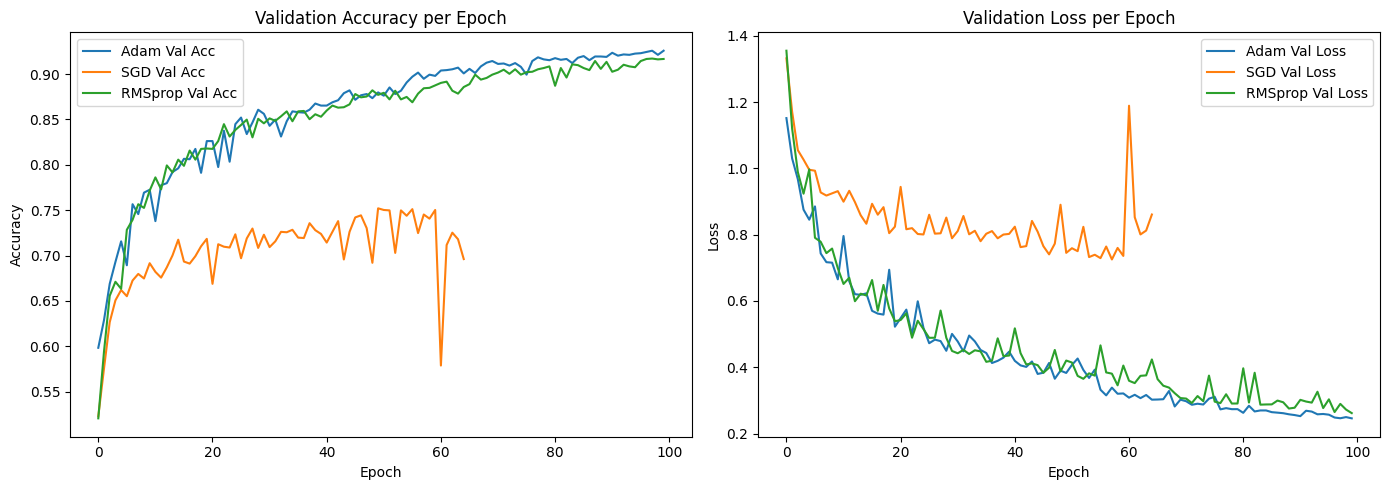

In [9]:
plot_optimizer_comparison(results)

In [22]:
# Evaluate models

def evaluate_model(model):
    try:
        print(f"Evaluating FCNN model with optimizer: {name}")
        test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
        print(f"Test accuracy: {test_acc:.4f}")
    except Exception as e:
        print(f"Error during evaluation: {e}")
    
    # Generate predictions, compute evaluation report and confusion matrix
    try:
        print("Generating predictions...")
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_cat, axis=1)

        print("\nClassification Report:")
        report = classification_report(y_test_classes, y_pred_classes, 
                                      target_names=label_encoder.classes_)
        print(report)
        
        cm = tf.math.confusion_matrix(y_test_classes, y_pred_classes).numpy()
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for FCNN with {name}')
        plt.tight_layout()
        plt.savefig(f'fcnn_{name}_confusion_matrix.png')
        
        # Calculate per-genre accuracy
        genre_acc = {}
        for i, genre in enumerate(label_encoder.classes_):
            genre_indices = y_test_classes == i
            if np.sum(genre_indices) > 0:  # Avoid division by zero
                genre_acc[genre] = np.mean(y_pred_classes[genre_indices] == i)
        
        # Print per-genre accuracy
        print("\nPer-genre accuracy:")
        for genre, acc in genre_acc.items():
            print(f"{genre}: {acc:.3f}")

    except Exception as e:
        print(f"Error during prediction/visualization: {e}")
        
        
        
# Save the scaler for later use
import joblib
joblib.dump(scaler_30sec, 'feature_scaler.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')
print("Scaler and encoder saved")
        

    
    

Scaler and encoder saved


Evaluating FCNN model with optimizer: Adam
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9346 - loss: 0.2273
Test accuracy: 0.9258
Generating predictions...
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

       blues       0.93      0.96      0.95       220
   classical       0.94      0.97      0.95       219
     country       0.89      0.92      0.91       219
       disco       0.89      0.91      0.90       220
      hiphop       0.93      0.94      0.93       220
        jazz       0.93      0.93      0.93       220
       metal       0.95      0.96      0.95       220
         pop       0.92      0.91      0.92       220
      reggae       0.95      0.92      0.93       220
        rock       0.92      0.83      0.88       220

    accuracy                           0.93      2198
   macro avg       0.93      0.93      0.93      2198
weighted avg       0.93      0.93      0.93      2198


Per-genre acc

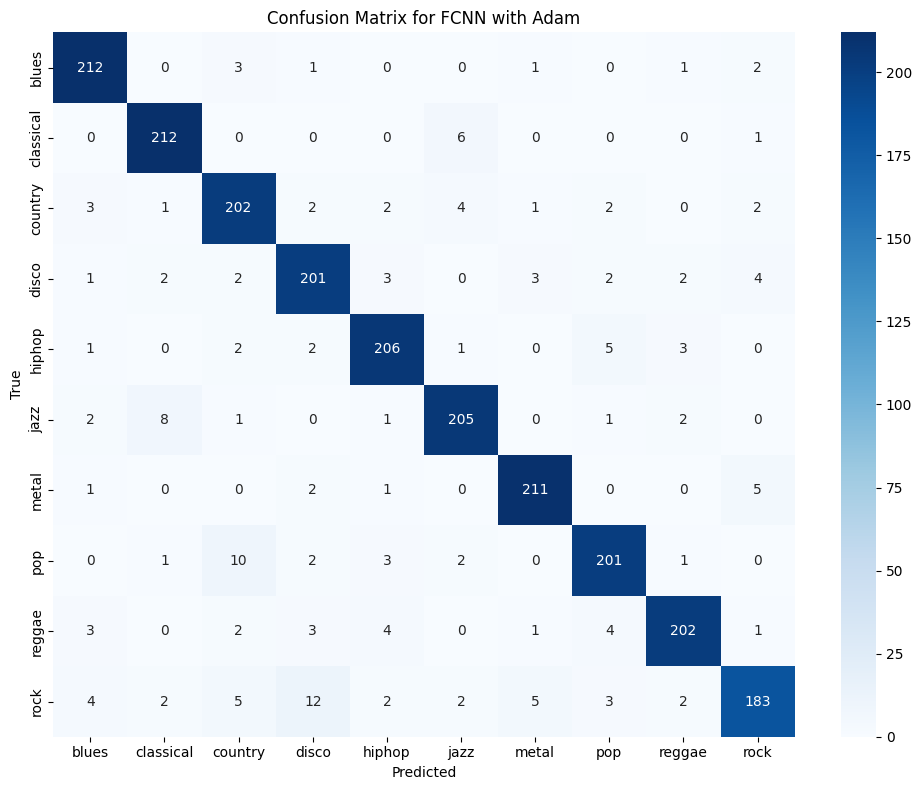

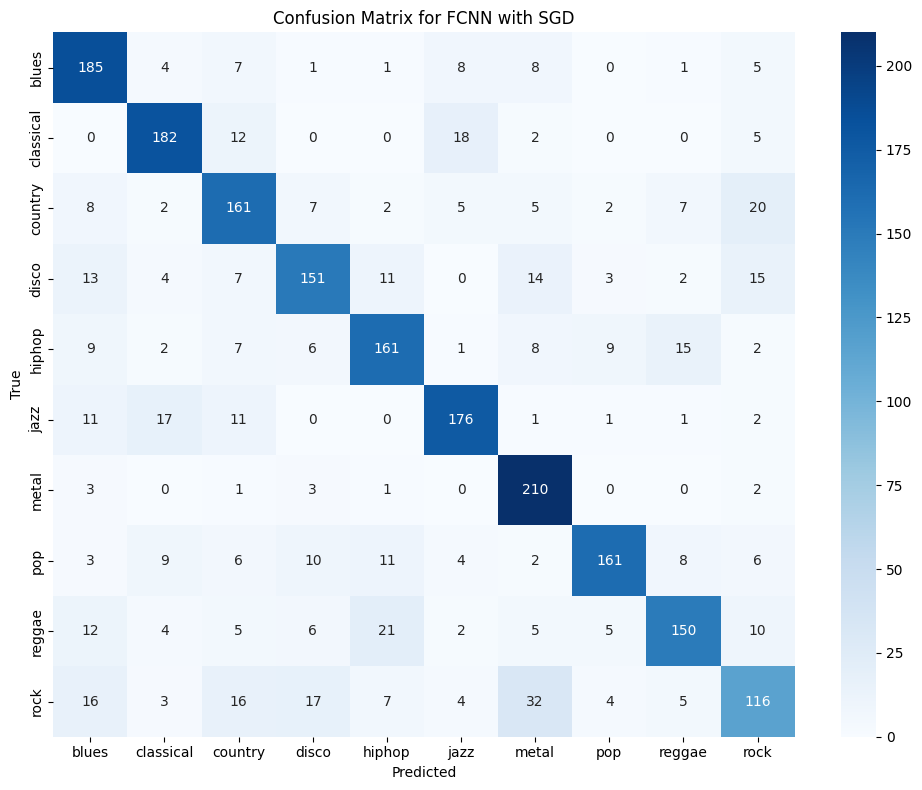

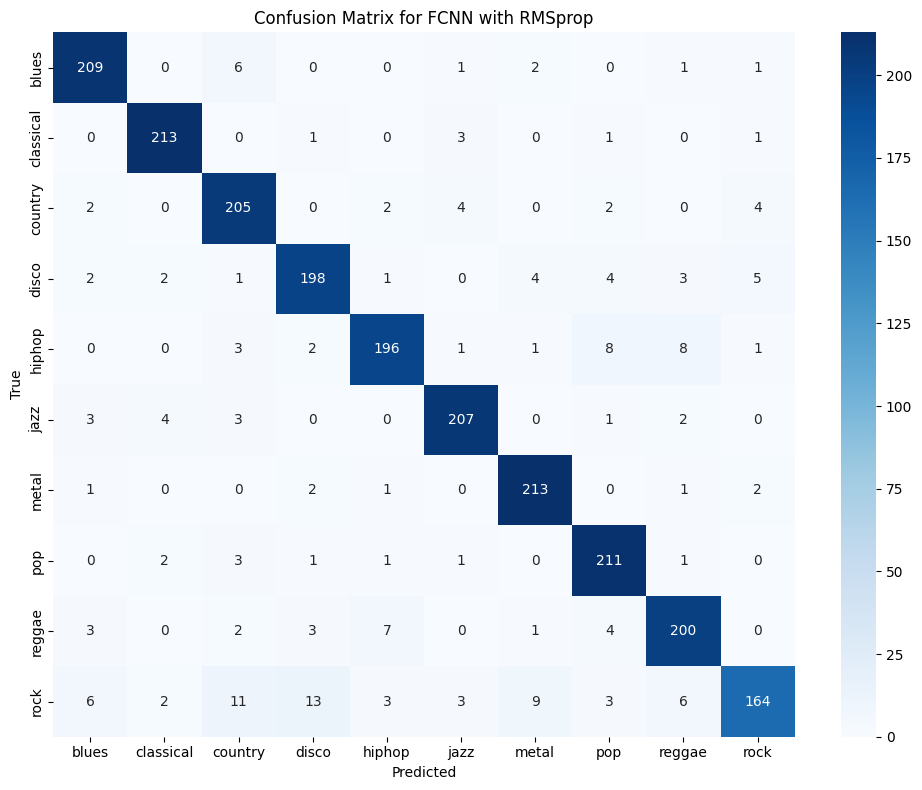

In [23]:
for name, model in models.items():
    evaluate_model(model)